In [1]:
import os
import seaborn as sns
import pandas as pd
from libraries import clustering
from scipy.spatial.distance import squareform

DATASET_DIR = "dataset" + os.sep
RESULTS_DIR = "results" + os.sep

In [2]:
merged_df = pd.read_csv(DATASET_DIR + "merge_clean_v2-AD.csv", parse_dates=["date"])
cyclist_df = pd.read_csv(DATASET_DIR + "cyclist_clean_v2-AD.csv")
stages_df = pd.read_csv(DATASET_DIR + "stages_clean_v2-AD.csv", parse_dates=["date"])

Prepare the tables deleting the attributes that we do not want to consider for the anomaly detection for the clustering

In [3]:
# Drop unnecessary columns from the 'cyclist_df' DataFrame.
# The columns to be removed are 'name', 'nationality', 'continent', and 'BMI'.
# These columns are dropped because they are not needed for the analysis.
cyclist_df.drop(columns=["name", "nationality", 'continent', "BMI"], inplace=True)

# Drop unnecessary columns from the 'stages_df' DataFrame.
# The columns to be removed are 'stage', 'date', and 'race'.
# These columns are dropped because they are not required for the analysis.
stages_df.drop(columns=["stage", "date", "race"], inplace=True)

# Drop unnecessary columns from the 'merged_df' DataFrame.
# The columns to be removed are 'date', 'race', 'stage', 'nationality', 'profile', 'season', 'points', and 'climb_total'.
# These columns are removed as they are not relevant for the final dataset.
merged_df.drop(columns=["date", "race", "stage", "nationality", 'profile', 'season', 'points', 'climb_total'], inplace=True)

# Reset the index for 'merged_df' to ensure that the indices are continuous after dropping columns or rows.
# drop=True ensures that the old index is not added as a new column.
merged_df.reset_index(drop=True, inplace=True)

# Reset the index for 'cyclist_df' in the same manner, ensuring that indices are continuous.
cyclist_df.reset_index(drop=True, inplace=True)

# Reset the index for 'stages_df' similarly, so the indices are continuous after column removal.
stages_df.reset_index(drop=True, inplace=True)

# Remove any rows with missing values (NaN) in the 'merged_df' DataFrame.
# This ensures that the dataset contains only complete rows, with no missing data.
merged_df = merged_df.dropna()

# Remove any rows with missing values (NaN) in the 'cyclist_df' DataFrame.
# This cleans the data and ensures that the dataset has no incomplete rows.
cyclist_df = cyclist_df.dropna()

# Remove any rows with missing values (NaN) in the 'stages_df' DataFrame.
# This ensures that there are no incomplete rows in the stages dataset.
stages_df = stages_df.dropna()


scale all

In [4]:
# List of categorical columns for transformation in the 'cyclist_df' DataFrame.
# These columns will not be transformed since we are leaving them as categorical features.
cat_cyclist = []

# List of columns to standardize in the 'cyclist_df' DataFrame.
# These columns will be standardized (i.e., scaled to have mean 0 and standard deviation 1).
stand_cyclist = ["height", "birth_year", 'avg_pos', 'num_races']

# List of columns to apply MinMax scaling in the 'cyclist_df' DataFrame.
# In this case, there are no columns specified for MinMax scaling.
minmax_cyclist = []

# Apply the transformation to the 'cyclist_df' DataFrame using the 'clustering.transform' method.
# It applies standardization, MinMax scaling, and encoding for categorical columns (if any).
# The result is the transformed data and the preprocessor (which holds information about how the data was transformed).
transformed_cyclists_data, preprocessor_cyclists = clustering.transform(
    cyclist_df,
    categorical_cols=cat_cyclist,
    standardize_cols=stand_cyclist,
    minmax_cols=minmax_cyclist,
)

# List of categorical columns for transformation in the 'stages_df' DataFrame.
# These columns are not specified here, as no categorical columns are being transformed.
cat_stage = []

# List of columns to standardize in the 'stages_df' DataFrame.
# These columns will be standardized (i.e., scaled to have mean 0 and standard deviation 1).
stand_stage = ["year", "length", "startlist_quality", 'avg_age_by_url', 'avg_delta_by_url', 'min_age_by_url', 'points']

# List of columns to apply MinMax scaling in the 'stages_df' DataFrame.
# Again, no columns are specified for MinMax scaling.
minmax_stage = []

# Apply the transformation to the 'stages_df' DataFrame using the 'clustering.transform' method.
# This applies standardization, MinMax scaling, and encoding for categorical columns (if any).
transformed_stages_data, preprocessor_stages = clustering.transform(
    stages_df,
    categorical_cols=cat_stage,
    minmax_cols=minmax_stage,
    standardize_cols=stand_stage
)

# Convert the transformed data for cyclists into a DataFrame.
# The transformed data now contains the processed values based on the specified transformations.
transformed_cyclists_df = pd.DataFrame(transformed_cyclists_data)

# Convert the transformed data for stages into a DataFrame.
# Similarly, the transformed stage data is now structured into a DataFrame.
transformed_stages_df = pd.DataFrame(transformed_stages_data)

# Add back the one-hot encoded columns' names to the transformed DataFrame for cyclists.
# This ensures that the transformed DataFrame has appropriate column names reflecting the transformations applied.
transformed_cyclists_df.columns = preprocessor_cyclists.get_feature_names_out(
    cyclist_df.columns
)

# Add back the one-hot encoded columns' names to the transformed DataFrame for stages.
# This ensures that the transformed DataFrame for stages has appropriate column names.
transformed_stages_df.columns = preprocessor_stages.get_feature_names_out(
    stages_df.columns
)

# Reset the index of the transformed cyclists DataFrame to ensure that indices are continuous after transformation.
transformed_cyclists_df.reset_index(drop=True, inplace=True)

# Reset the index of the transformed stages DataFrame in the same way to ensure continuous indices.
transformed_stages_df.reset_index(drop=True, inplace=True)

# Add the '_url' column back to the transformed cyclists DataFrame.
# The '_url' column is kept from the original 'cyclist_df' DataFrame for reference.
transformed_cyclists_df["_url"] = cyclist_df["_url"]

# Add the '_url' column back to the transformed stages DataFrame for reference.
transformed_stages_df["_url"] = stages_df["_url"]

# Drop the '_url' column from the transformed cyclists DataFrame as it's no longer needed after adding it back.
transformed_cyclists_df.drop(columns=["_url"], inplace=True)

# Drop the '_url' column from the transformed stages DataFrame similarly.
transformed_stages_df.drop(columns=["_url"], inplace=True)


In [5]:
def filter_one_hot_columns(df):
    return df.loc[:, ~df.columns.str.startswith("cat__")]


real_cyclists_df = filter_one_hot_columns(transformed_cyclists_df)
real_stages_df = filter_one_hot_columns(transformed_stages_df)

real_cyclists_df.info()
real_stages_df.info()

cyclists = cyclist_df
stages = stages_df

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3039 entries, 0 to 3038
Data columns (total 4 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   standardize__height      3039 non-null   float64
 1   standardize__birth_year  3039 non-null   float64
 2   standardize__avg_pos     3039 non-null   float64
 3   standardize__num_races   3039 non-null   float64
dtypes: float64(4)
memory usage: 95.1 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3021 entries, 0 to 3020
Data columns (total 7 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   standardize__year               3021 non-null   float64
 1   standardize__length             3021 non-null   float64
 2   standardize__startlist_quality  3021 non-null   float64
 3   standardize__avg_age_by_url     3021 non-null   float64
 4   standardize__avg_delta_by_url   3021 non-null   floa

### Distributional approach

Try gaussian mixture

In [6]:
import numpy as np
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt


def dist_tune(df):
    aic_values = []
    bic_values = []
    k_range = range(1, 50)  # Testa valori di k da 1 a 10

    for k in k_range:
        gmm = GaussianMixture(n_components=k, random_state=1804)
        gmm.fit(df.values)
        aic_values.append(gmm.aic(df.values))
        bic_values.append(gmm.bic(df.values))

    # Grafico dei valori AIC e BIC
    plt.figure(figsize=(10, 6))
    plt.plot(k_range, aic_values, label='AIC', marker='o')
    plt.plot(k_range, bic_values, label='BIC', marker='o')
    plt.xlabel('Numero di Componenti (k)')
    plt.ylabel('AIC/BIC')
    plt.title('Selezione del numero ottimale di componenti')
    plt.legend()
    plt.show()

Try tuning with AIC BIC

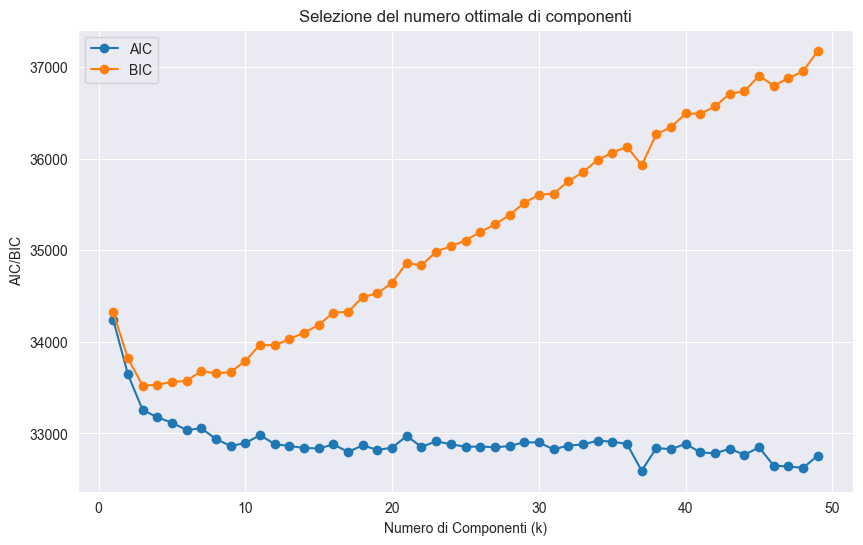

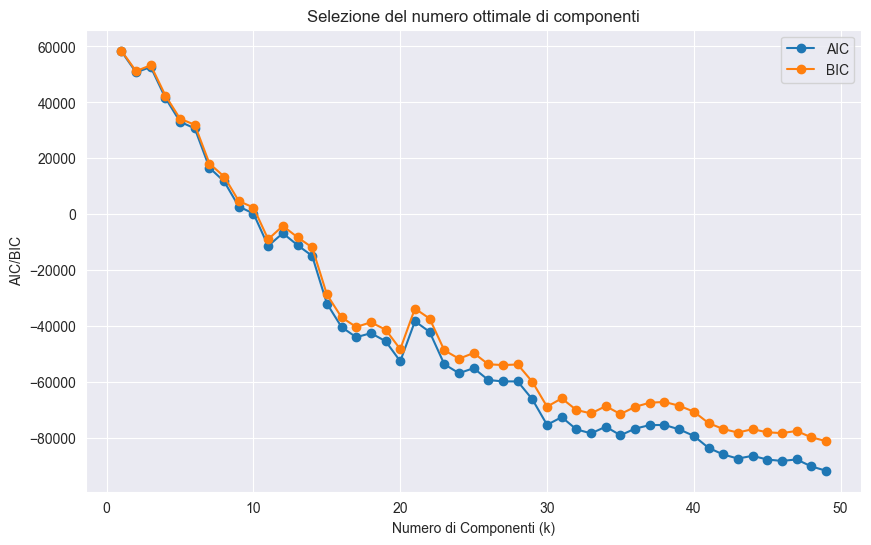

In [7]:
dist_tune(real_cyclists_df)
dist_tune(real_stages_df)

In [8]:
def dist_plot(df, res_df, k):
    algorithm = GaussianMixture(n_components=k)
    algorithm.fit(df.values)
    
    outlier_degrees_per_normal = algorithm.predict_proba(df.values)
    outlier_degrees = outlier_degrees_per_normal.max(axis=1)
    
    res_df.loc[:, "density_degree"] = outlier_degrees
    sorted_outlier_degrees = sorted(outlier_degrees)
    outlier_degrees_cdf = np.cumsum(sorted_outlier_degrees)
    
    sns.lineplot(
        x=range(df.shape[0]),
        y=sorted_outlier_degrees
    )
    plt.show()

We go for curse of dimentionality rule

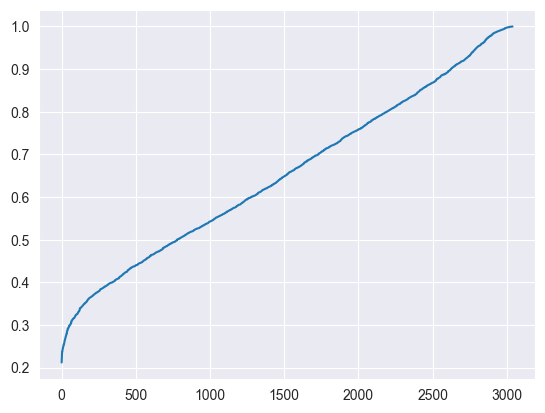

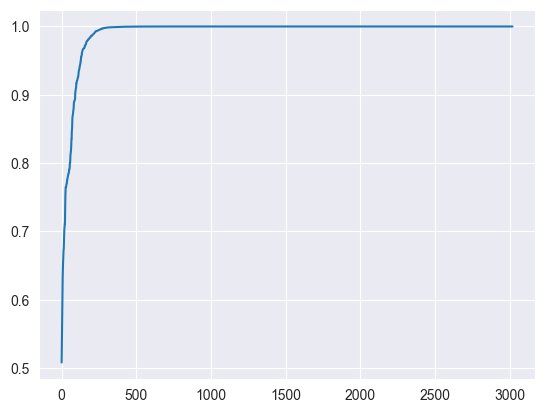

In [9]:
dist_plot(real_cyclists_df, cyclists, pow(2, real_cyclists_df.shape[1]))
dist_plot(real_stages_df, stages, pow(2, real_stages_df.shape[1]))

### Connectivity approach

tune the connectivity graph

In [10]:
from sklearn.metrics import silhouette_score
from sklearn.neighbors import LocalOutlierFactor

def conn_tune(df):
    k_values = range(2, 50, 2)
    silhouette_scores = []

    for k in k_values:
        lof = LocalOutlierFactor(n_neighbors=k)
        labels = lof.fit_predict(df)
        score = silhouette_score(df, labels)
        silhouette_scores.append(score)
    
    best_k = k_values[np.argmax(silhouette_scores)]
    
    sns.lineplot(
        x=range(2,50,2),
        y=silhouette_scores
    )
    print(f"Best k based on silhouette: {best_k}")
    plt.show()
    
    k_values = range(5, 50, 10)
    for k in k_values:
        lof = LocalOutlierFactor(n_neighbors=k)
        lof.fit(df)
        scores = -lof.negative_outlier_factor_
        plt.plot(sorted(scores), label=f"k={k}")
    
    plt.xlabel("Instances (sorted)")
    plt.ylabel("LOF scores")
    plt.legend()
    plt.title("Distribuzione dei punteggi LOF per diversi valori di k")
    plt.show()

Tuning 

Best k based on silhouette: 10


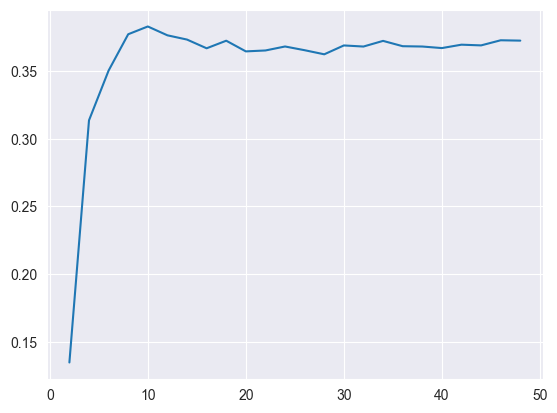

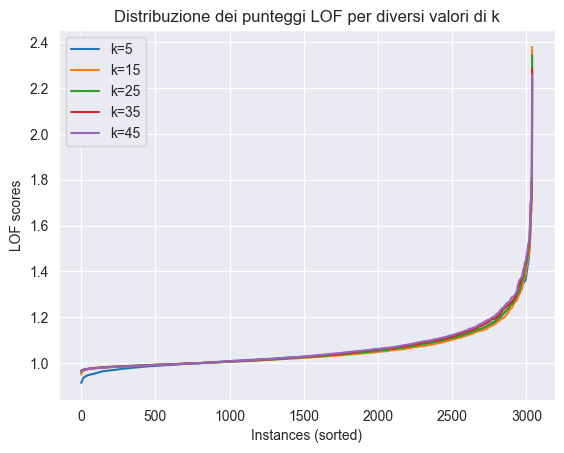

Best k based on silhouette: 18


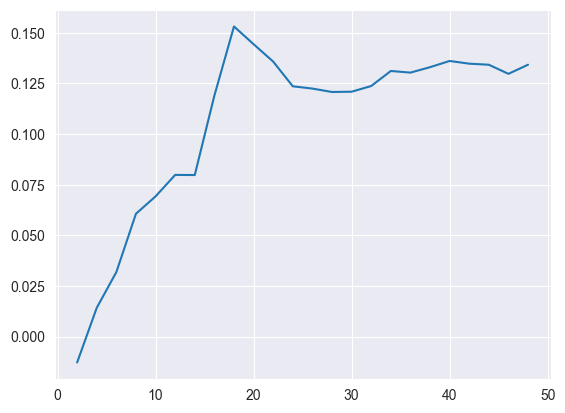

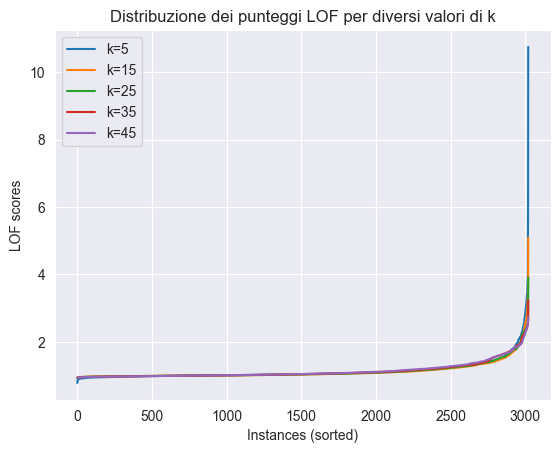

In [11]:
conn_tune(real_cyclists_df)
conn_tune(real_stages_df)

let's do for choosen K

In [12]:
from scipy.spatial.distance import pdist
from sklearn.neighbors import LocalOutlierFactor

def conn_plot(df, res_df, k):
    k=int(k)
    algorithm = LocalOutlierFactor(n_neighbors=k)
    algorithm.fit(df)
    
    # negated outlier scores: the higher, the more of an outlier
    outlier_degrees = - algorithm.negative_outlier_factor_
    
    sorted_outlier_degrees = sorted(outlier_degrees)
    
    # to achieve comparable degrees among different algorithms,
    # we normalize distance-based scores by the maximum possible distance
    distances = squareform(pdist(df.values))
    maximum_possible_radius = distances.max()
    normalization_factor = maximum_possible_radius / k
    normalized_sorted_outlier_degrees = sorted_outlier_degrees / normalization_factor
    
    res_df.loc[:, "lof_degree_normalized"] = outlier_degrees / normalization_factor
    
    print(normalized_sorted_outlier_degrees)
    sns.lineplot(
        x=range(df.shape[0]),
        y=sorted_outlier_degrees
    )
    plt.show()

We opt for the rule of thumb of log2(#rows) for K

[1.19198305 1.1920463  1.1924934  ... 2.23539456 2.25369801 3.00832609]


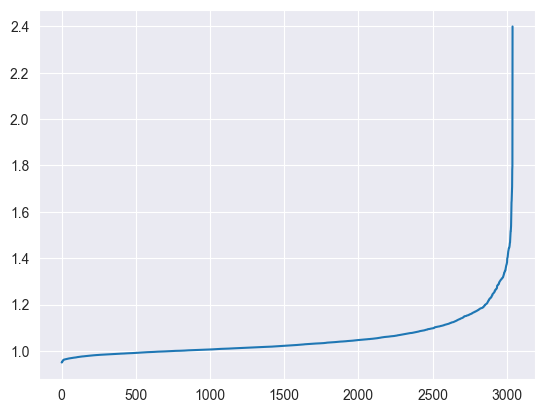

[0.94127274 0.95310606 0.95310606 ... 3.91172982 4.51571895 5.94645402]


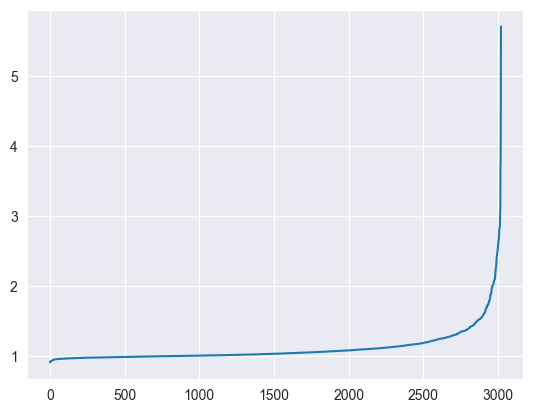

In [13]:
conn_plot(real_cyclists_df, cyclists, np.log2(real_cyclists_df.shape[0]))
conn_plot(real_stages_df, stages, np.log2(real_stages_df.shape[0]))

### SVM

Let's try with one class svm

In [14]:
from sklearn.svm import OneClassSVM


def svm_plot(df, res_df, kernel='rbf'):
    df = df.copy()
    
    algorithm = OneClassSVM(kernel=kernel)
    algorithm.fit(df)
    
    # this implementation provides two different scores:
    #   outlier classification in {+1, -1}
    #   outlier scores in R: distance from hyperplane
    outlier_classification_scores = algorithm.predict(df)
    outlier_distance_scores = algorithm.score_samples(df)

    sorted_outlier_degrees = sorted(outlier_distance_scores)
    
    # to achieve comparable degrees among different algorithms, we normalize distance-based scores by the maximum possible distance
    normalization_factor = sorted_outlier_degrees[-1]
    normalized_sorted_outlier_degrees = sorted_outlier_degrees / normalization_factor
    
    res_df.loc[:, "oneclass_svm_degree_normalized"] = outlier_distance_scores / normalization_factor
    res_df.loc[:, "oneclass_svm_degree_binary"] = 1 - (outlier_classification_scores  + 1) / 2  # map to {0, 1}
    
    sns.lineplot(
        x=range(df.shape[0]),
        y=sorted_outlier_degrees
    )    
    plt.figure(figsize=(6,6))
    plt.show()

try different kernels. we take the results from rbf with auto tuning of hyper parameters

Cyclists:


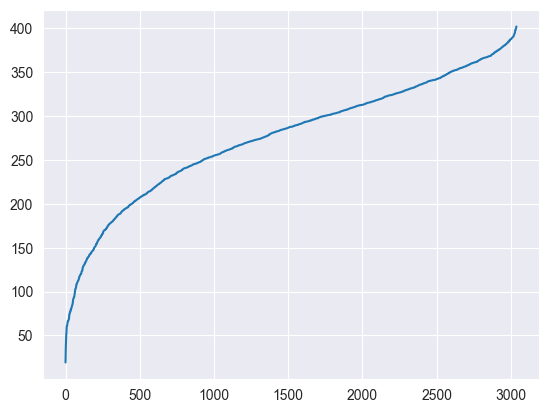

<Figure size 600x600 with 0 Axes>

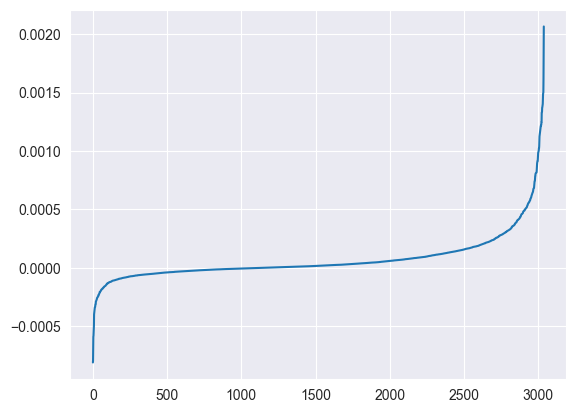

<Figure size 600x600 with 0 Axes>

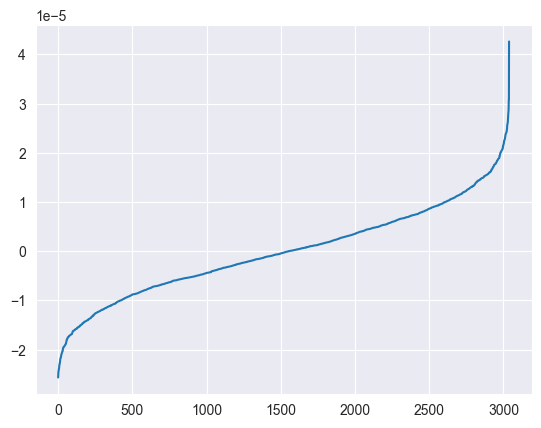

<Figure size 600x600 with 0 Axes>

Stages:


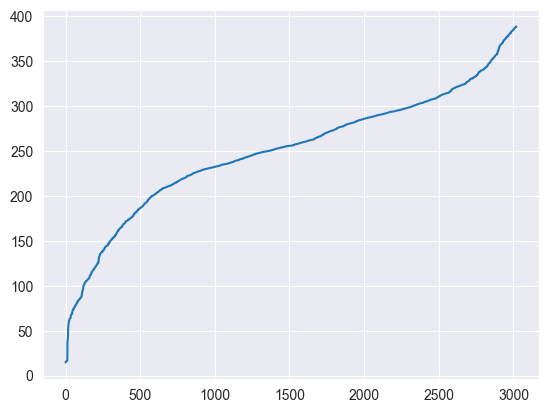

<Figure size 600x600 with 0 Axes>

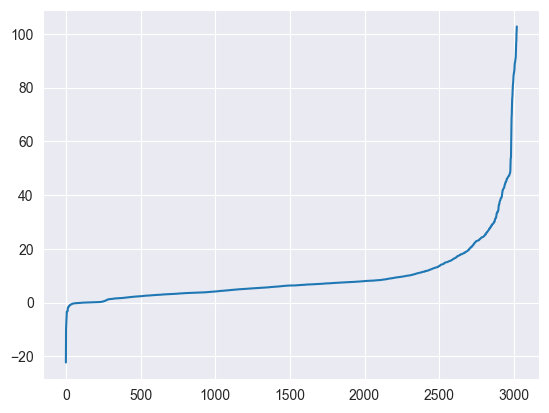

<Figure size 600x600 with 0 Axes>

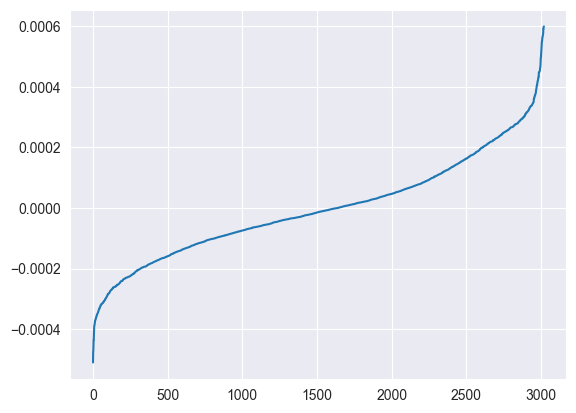

<Figure size 600x600 with 0 Axes>

In [15]:
print("Cyclists:")
svm_plot(real_cyclists_df, cyclists, 'rbf')
svm_plot(real_cyclists_df, pd.DataFrame(), 'poly')
svm_plot(real_cyclists_df, pd.DataFrame(), 'linear')
print("Stages:")
svm_plot(real_stages_df, stages, 'rbf')
svm_plot(real_stages_df, pd.DataFrame(), 'poly')
svm_plot(real_stages_df, pd.DataFrame(), 'linear')

### Isolation forests

Let's try isolation forests

In [16]:
from sklearn.ensemble import IsolationForest


def iso_plot(df, res_df):
    max_features = df.shape[1]
    algorithm = IsolationForest(max_features=max_features, random_state=1804)
    algorithm.fit(df)
    # the lower, more outliers
    outlier_degrees = algorithm.decision_function(df) + 0.5
    outlier_scores = 1 - (algorithm.predict(df) + 1) / 2 # outlier become +1, inliers become 0. (i map -1, 1)
    
    res_df.loc[:, "isolation_forest_degree"] = outlier_degrees
    res_df.loc[:, "isolation_forest_scores"] = outlier_scores
    
    sorted_outlier_degrees = sorted(outlier_degrees)
    
    sns.lineplot(
        x=range(df.shape[0]),
        y=sorted_outlier_degrees
    )

apply to tables

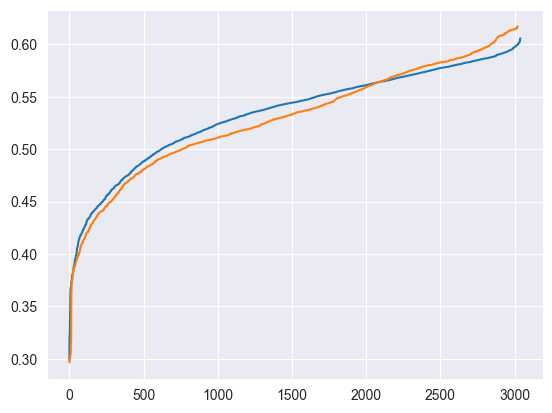

In [17]:
iso_plot(real_cyclists_df, cyclists)
iso_plot(real_stages_df, stages)

### Summary

check results

In [18]:
print(cyclist_df)
print(stages)

                       _url  birth_year  height     avg_pos  num_races  \
0            johann-van-zyl        1991   190.0   70.818182         11   
1             robert-hunter        1977   178.0  117.959707        273   
2        anass-ait-el-abdia        1993   180.0   60.691489        564   
3             negasi-abreha        2000   186.0  103.792952        227   
4                  ryan-cox        1979   177.0   44.640091        439   
...                     ...         ...     ...         ...        ...   
3034          jhojan-garcia        1998   168.0   98.836000        250   
3035      alvaro-jose-hodeg        1996   186.0   44.541833        753   
3036   aldemar-reyes-ortega        1995   170.0   70.159827        463   
3037  eric-antonio-fagundez        1998   180.0   95.022890        699   
3038      jackson-rodriguez        1985   170.0   96.025346        434   

      density_degree  lof_degree_normalized  oneclass_svm_degree_normalized  \
0           0.526563            

Create function to remove outliers. Majority vote across the methods. if 3/4 YES then it's outlier else No

In [19]:
def out_remove(df):
    threshold1 = np.percentile(df["lof_degree_normalized"], 10)
    threshold2 = np.percentile(df["density_degree"], 10)
    rows_to_drop = []

    # Loop through each row in the dataframe
    for idx, point in df.iterrows():
        c = 0  # Counter for the number of outlier conditions met
        
        # Checking different outlier conditions:
        if point['isolation_forest_scores']:  # If IsolationForest score indicates outlier
            c += 1
        if point['oneclass_svm_degree_binary']:  # If OneClassSVM degree is 1 (outlier)
            c += 1
        if point["lof_degree_normalized"] < threshold1:  # If LOF degree is below threshold
            c += 1
        if point["density_degree"] < threshold2:  # If GMM density degree is below threshold
            c += 1
        
        # If more than 2 outlier conditions are met, mark the point for removal
        if c >= 3:
            rows_to_drop.append(idx)
    
    # Drop the rows that are marked as outliers
    df.drop(rows_to_drop, axis=0, inplace=True)

Check size before, remove outliers, check new size

In [20]:
print(cyclists.shape)
print(stages.shape)

out_remove(cyclists)
out_remove(stages)

print(cyclists.shape)
print(stages.shape)

(3039, 11)
(3021, 17)
(3020, 11)
(2895, 17)


In [21]:
cyclists.info()
stages.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3020 entries, 0 to 3038
Data columns (total 11 columns):
 #   Column                          Non-Null Count  Dtype  
---  ------                          --------------  -----  
 0   _url                            3020 non-null   object 
 1   birth_year                      3020 non-null   int64  
 2   height                          3020 non-null   float64
 3   avg_pos                         3020 non-null   float64
 4   num_races                       3020 non-null   int64  
 5   density_degree                  3020 non-null   float64
 6   lof_degree_normalized           3020 non-null   float64
 7   oneclass_svm_degree_normalized  3020 non-null   float64
 8   oneclass_svm_degree_binary      3020 non-null   float64
 9   isolation_forest_degree         3020 non-null   float64
 10  isolation_forest_scores         3020 non-null   float64
dtypes: float64(8), int64(2), object(1)
memory usage: 283.1+ KB
<class 'pandas.core.frame.DataFrame'>
Ind

Drop columns associated to results of anomaly detection emthods.

In [22]:
columns_to_drop = cyclists.columns[5:11]  # Adjust the range as needed
cyclists.drop(columns_to_drop, axis=1, inplace=True)

columns_to_drop = stages.columns[11:17]  # Adjust the range as needed
stages.drop(columns_to_drop, axis=1, inplace=True)

In [23]:
cyclists.info()
stages.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3020 entries, 0 to 3038
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   _url        3020 non-null   object 
 1   birth_year  3020 non-null   int64  
 2   height      3020 non-null   float64
 3   avg_pos     3020 non-null   float64
 4   num_races   3020 non-null   int64  
dtypes: float64(2), int64(2), object(1)
memory usage: 141.6+ KB
<class 'pandas.core.frame.DataFrame'>
Index: 2895 entries, 0 to 3017
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   _url               2895 non-null   object 
 1   points             2895 non-null   int64  
 2   length             2895 non-null   int64  
 3   climb_total        2895 non-null   int64  
 4   profile            2895 non-null   int64  
 5   startlist_quality  2895 non-null   int64  
 6   year               2895 non-null   int64  
 7   season   

save results

In [24]:
cyclists.to_csv('dataset/cyclist_clean_v3.csv')
stages.to_csv('dataset/stages_clean_v3.csv')